In [ ]:
import pandas as pd

house_prices = pd.read_csv('https://raw.githubusercontent.com/JoanClaverol/housing_regression_data/main/train.csv')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error 
import pickle

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Let's Take a brief look at the data (Data types, rows, columns, nulls)

In [ ]:
house_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Do we know more or less where the average price stands?

In [ ]:
price_avg = house_prices.SalePrice.mean()
price_avg


180921.19589041095

What about the mode?

In [ ]:
price_mode = house_prices.SalePrice.mode()
price_mode

0    140000
dtype: int64

When were the houses built?



In [ ]:
Year_mode = house_prices.YearBuilt.mode()
Year_mode


0    2006
dtype: int64

What about in average?

In [ ]:
Year_median = house_prices.YearBuilt.median()
Year_median 

1973.0

We can already foresee the dispersion of the data based on the difference between the mode and the mean and media, but this is not conclussive. So let's have a look at the data on a graphic

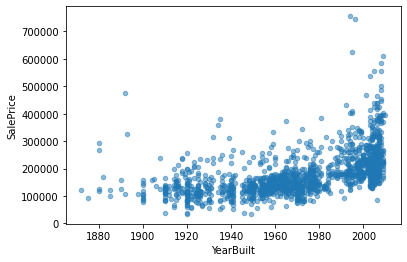

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

house_prices.plot.scatter(x = "YearBuilt", y = "SalePrice", alpha = 0.5) 

plt.show()



Let's calculate the Standard Deviation, outliers, just to be sure, and

In [ ]:
house_prices['SalePrice'].std() 

79442.50288288662

In [ ]:
print(np.quantile(house_prices['SalePrice'], [0, 0.25, 0.5, 0.75, 1]))


[ 34900. 129975. 163000. 214000. 755000.]


In [ ]:
IQR = np.quantile(house_prices['SalePrice'], 0.75) - np.quantile(house_prices['SalePrice'], 0.25)
print(IQR)

84025.0


Let's observe the outliers

In [ ]:
from scipy.stats import iqr

IQR = iqr(house_prices['SalePrice'])
print(IQR)

84025.0


In [ ]:
# first get iqr
iqr= iqr(house_prices['SalePrice'])
# then get lower & upper threshold
lower_threshold = np.quantile(house_prices['SalePrice'], 0.25)
upper_threshold = np.quantile(house_prices['SalePrice'], 0.75)
# One way to find outliers 
outliers_1 = house_prices[(house_prices['SalePrice'] < lower_threshold) | (house_prices['SalePrice'] > upper_threshold)]
print(outliers_1)

        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
6        7          20       RL         75.0    10084   Pave   NaN      Reg   
8        9          50       RM         51.0     6120   Pave   NaN      Reg   
9       10         190       RL         50.0     7420   Pave   NaN      Reg   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1448  1449          50       RL         70.0    11767   Pave   NaN      Reg   
1449  1450         180       RM         21.0     1533   Pave   NaN      Reg   
1451  1452          20       RL         78.0     9262   Pave   NaN      Reg   
1453  1454          20       RL         90.0    17217   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fe

Other way to calculate outliers and create a column with the values to then filter those out from the model

In [ ]:
from scipy.stats import zscore

In [ ]:
# calculates z-score values
house_prices["zscore"] = zscore(house_prices['SalePrice']) 

In [ ]:
# creates `is_outlier` column with either True or False values, 
# so that you could filter your dataframe accordingly
house_prices["is_outlier"] = house_prices["zscore"].apply(lambda x: x <= -1.96 or x >= 1.96)

In [ ]:
house_prices

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,zscore,is_outlier
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,2,2008,WD,Normal,208500,0.347273,False
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,5,2007,WD,Normal,181500,0.007288,False
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,9,2008,WD,Normal,223500,0.536154,False
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,2,2006,WD,Abnorml,140000,-0.515281,False
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,12,2008,WD,Normal,250000,0.869843,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,8,2007,WD,Normal,175000,-0.074560,False
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,MnPrv,NaN,0,2,2010,WD,Normal,210000,0.366161,False
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,GdPrv,Shed,2500,5,2010,WD,Normal,266500,1.077611,False
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,4,2010,WD,Normal,142125,-0.488523,False


Variance and Standard deviation are other ways to evaluate how spread the data is

In [ ]:
print(np.var(house_prices['SalePrice'], ddof=1))


6311111264.297448


In [ ]:
print(np.std(house_prices['SalePrice'], ddof=1))


79442.50288288662


In [ ]:
# find the distance between the data points and the mean
dists = house_prices['SalePrice'] - np.mean(house_prices['SalePrice'])
# find the mean absolute 
print(np.mean(np.abs(dists)))

57434.77027584912


In [ ]:
import matplotlib.pyplot as plt
import numpy as np



In [ ]:
house_prices.select_dtypes(exclude=[object]).isnull().sum()


Id                 0
MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
zscore             0
is_outlier         0
dtype: int64

In [ ]:
house_prices.Neighborhood.unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

In [ ]:
Neig_price= house_prices[['Id', 'LotArea','Neighborhood','YearBuilt','YearRemodAdd','SalePrice', 'is_outlier']]
Neig_price


,Id,LotArea,Neighborhood,YearBuilt,YearRemodAdd,SalePrice,is_outlier
0,1,8450,CollgCr,2003,2003,208500,False
1,2,9600,Veenker,1976,1976,181500,False
2,3,11250,CollgCr,2001,2002,223500,False
3,4,9550,Crawfor,1915,1970,140000,False
4,5,14260,NoRidge,2000,2000,250000,False
...,...,...,...,...,...,...,...
1455,1456,7917,Gilbert,1999,2000,175000,False
1456,1457,13175,NWAmes,1978,1988,210000,False
1457,1458,9042,Crawfor,1941,2006,266500,False
1458,1459,9717,NAmes,1950,1996,142125,False


In [ ]:
from numpy.core.fromnumeric import shape

Neig_price1 = Neig_price.nunique(axis=0)
Neig_price1


Id              1460
LotArea         1073
Neighborhood      25
YearBuilt        112
YearRemodAdd      61
SalePrice        663
is_outlier         2
dtype: int64

In [ ]:
Neig_price = house_prices.assign(
    price_xSQF = lambda x: x.SalePrice / x.LotArea,
    Neig_H_size = lambda x: x.SalePrice / x.price_xSQF,
    Difference = lambda x: x.Neig_H_size * x.price_xSQF - x.SalePrice
    )

Neig_price


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice,zscore,is_outlier,price_xSQF,Neig_H_size,Difference
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,2,2008,WD,Normal,208500,0.347273,False,24.674556,8450.0,0.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,5,2007,WD,Normal,181500,0.007288,False,18.906250,9600.0,0.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,9,2008,WD,Normal,223500,0.536154,False,19.866667,11250.0,0.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,2,2006,WD,Abnorml,140000,-0.515281,False,14.659686,9550.0,0.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,12,2008,WD,Normal,250000,0.869843,False,17.531557,14260.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,8,2007,WD,Normal,175000,-0.074560,False,22.104332,7917.0,0.0
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,2,2010,WD,Normal,210000,0.366161,False,15.939279,13175.0,0.0
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,5,2010,WD,Normal,266500,1.077611,False,29.473568,9042.0,0.0
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,4,2010,WD,Normal,142125,-0.488523,False,14.626428,9717.0,0.0


In [ ]:
Neig_price2= pd.DataFrame().assign(Id = house_prices['Id'], Neighborhoods=Neig_price['Neighborhood'], LotArea=Neig_price['LotArea'],YearBuilt=Neig_price['YearBuilt'],
                                   YearRemodAdd=Neig_price['YearRemodAdd'], SalePrice=Neig_price['SalePrice'], 
                                   price_xSQF=Neig_price['price_xSQF'], Neig_H_size=Neig_price['Neig_H_size'], is_outlier = house_prices['is_outlier'])
Neig_price2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   Neighborhoods  1460 non-null   object 
 2   LotArea        1460 non-null   int64  
 3   YearBuilt      1460 non-null   int64  
 4   YearRemodAdd   1460 non-null   int64  
 5   SalePrice      1460 non-null   int64  
 6   price_xSQF     1460 non-null   float64
 7   Neig_H_size    1460 non-null   float64
 8   is_outlier     1460 non-null   bool   
dtypes: bool(1), float64(2), int64(5), object(1)
memory usage: 92.8+ KB


In [ ]:
is_outlier = Neig_price2[(Neig_price2['is_outlier'])].index
Neig_price2.drop(is_outlier , inplace=True)
Neig_price2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1394 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1394 non-null   int64  
 1   Neighborhoods  1394 non-null   object 
 2   LotArea        1394 non-null   int64  
 3   YearBuilt      1394 non-null   int64  
 4   YearRemodAdd   1394 non-null   int64  
 5   SalePrice      1394 non-null   int64  
 6   price_xSQF     1394 non-null   float64
 7   Neig_H_size    1394 non-null   float64
 8   is_outlier     1394 non-null   bool   
dtypes: bool(1), float64(2), int64(5), object(1)
memory usage: 99.4+ KB


In [ ]:
Neig_price2

,Id,Neighborhoods,LotArea,YearBuilt,YearRemodAdd,SalePrice,price_xSQF,Neig_H_size,is_outlier
0,1,CollgCr,8450,2003,2003,208500,24.674556,8450.0,False
1,2,Veenker,9600,1976,1976,181500,18.906250,9600.0,False
2,3,CollgCr,11250,2001,2002,223500,19.866667,11250.0,False
3,4,Crawfor,9550,1915,1970,140000,14.659686,9550.0,False
4,5,NoRidge,14260,2000,2000,250000,17.531557,14260.0,False
...,...,...,...,...,...,...,...,...,...
1455,1456,Gilbert,7917,1999,2000,175000,22.104332,7917.0,False
1456,1457,NWAmes,13175,1978,1988,210000,15.939279,13175.0,False
1457,1458,Crawfor,9042,1941,2006,266500,29.473568,9042.0,False
1458,1459,NAmes,9717,1950,1996,142125,14.626428,9717.0,False


In [ ]:
neigh_mean= Neig_price2.groupby(['Neighborhoods']).mean()
neigh_mean.sort_values('price_xSQF', ascending=False).reset_index()


,Neighborhoods,Id,LotArea,YearBuilt,YearRemodAdd,SalePrice,price_xSQF,Neig_H_size,is_outlier
0,Blueste,778.500000,1625.000000,1980.000000,1980.000000,137500.000000,86.410256,1625.000000,0.0
1,BrDale,719.187500,1801.000000,1971.437500,1973.625000,104493.750000,58.323157,1801.000000,0.0
2,Blmngtn,773.941176,3398.176471,2005.235294,2005.764706,194870.882353,57.643934,3398.176471,0.0
3,NPkVill,781.444444,3267.444444,1976.444444,1976.444444,142694.444444,49.577688,3267.444444,0.0
4,MeadowV,733.000000,2324.000000,1972.588235,1976.705882,98576.470588,45.394765,2324.000000,0.0
5,StoneBr,743.500000,6763.187500,1994.000000,1994.375000,239312.500000,39.123842,6763.187500,0.0
6,Somerst,767.024390,7588.890244,2004.926829,2005.219512,218402.902439,35.696822,7588.890244,0.0
7,NridgHt,613.040816,9485.775510,2005.326531,2005.775510,258822.979592,31.202999,9485.775510,0.0
8,NoRidge,775.535714,12611.142857,1995.321429,1996.428571,278378.857143,23.402910,12611.142857,0.0
9,CollgCr,728.175676,9614.472973,1997.770270,1999.033784,195175.851351,21.134088,9614.472973,0.0


In [ ]:
neigh_mean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, Blmngtn to Veenker
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            25 non-null     float64
 1   LotArea       25 non-null     float64
 2   YearBuilt     25 non-null     float64
 3   YearRemodAdd  25 non-null     float64
 4   SalePrice     25 non-null     float64
 5   price_xSQF    25 non-null     float64
 6   Neig_H_size   25 non-null     float64
 7   is_outlier    25 non-null     float64
dtypes: float64(8)
memory usage: 1.8+ KB


In [ ]:
Neig_price_copy = Neig_price2.replace({'Neighborhoods' : {
    "Blueste": "86.41", "BrDale": "58.32", "Blmngtn": "57.64", "NPkVill": "49.57", "MeadowV": "45.39", 
    "StoneBr": "36.07", "Somerst": "35.46", "NridgHt": "31.42", "NoRidge": "25.66", "CollgCr": "21.39",
    "Crawfor": "21.04", "SawyerW": "19.01", "SWISU": "18.63", "Gilbert": "18.57", "Timber": "18.38",
    "Veenker": "18.08", "BrkSide": "17.50", "OldTown": "17.03", "NWAmes": "16.50", "Mitchel": "16.43",
    "Edwards": "15.47", "NAmes": "15.08", "Sawyer": "13.96", "ClearCr": "13.78", "IDOTRR": "13.17",
    }})
Neig_price_copy = Neig_price_copy.astype({"Neighborhoods": float}, errors='raise') 
Neig_price_copy.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1394 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1394 non-null   int64  
 1   Neighborhoods  1394 non-null   float64
 2   LotArea        1394 non-null   int64  
 3   YearBuilt      1394 non-null   int64  
 4   YearRemodAdd   1394 non-null   int64  
 5   SalePrice      1394 non-null   int64  
 6   price_xSQF     1394 non-null   float64
 7   Neig_H_size    1394 non-null   float64
 8   is_outlier     1394 non-null   bool   
dtypes: bool(1), float64(3), int64(5)
memory usage: 99.4 KB


In [ ]:
Neig_price_copy = Neig_price_copy.drop(['is_outlier'], axis=1)
Neig_price_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1394 entries, 0 to 1459
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1394 non-null   int64  
 1   Neighborhoods  1394 non-null   float64
 2   LotArea        1394 non-null   int64  
 3   YearBuilt      1394 non-null   int64  
 4   YearRemodAdd   1394 non-null   int64  
 5   SalePrice      1394 non-null   int64  
 6   price_xSQF     1394 non-null   float64
 7   Neig_H_size    1394 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 98.0 KB


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
X = Neig_price_copy.drop(columns=['SalePrice'])
y = Neig_price_copy['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=8)
X_train.head()

,Id,Neighborhoods,LotArea,YearBuilt,YearRemodAdd,price_xSQF,Neig_H_size
294,295,15.08,9600,1953,1953,17.395833,9600.0
125,126,13.17,6780,1935,1982,12.463127,6780.0
884,885,15.08,7150,1967,1967,13.986014,7150.0
706,707,13.78,115149,1971,2002,2.622689,115149.0
1120,1121,13.17,8263,1920,1950,14.328936,8263.0


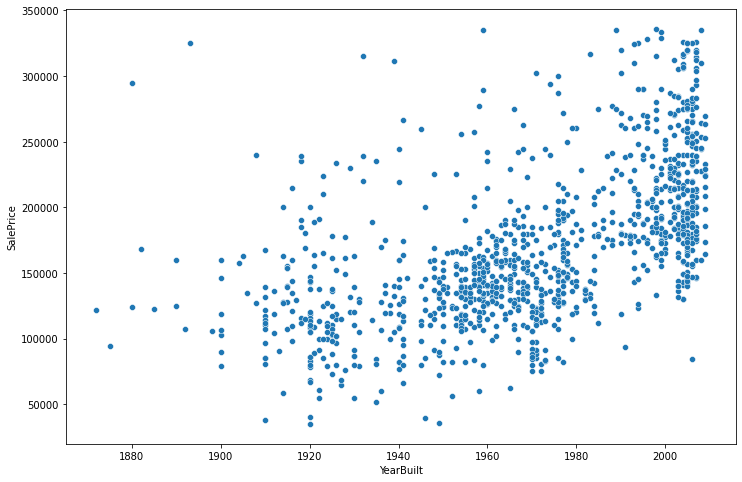

In [ ]:
plt.subplots(figsize=(12, 8))
sns.scatterplot(x=X_train['YearBuilt'], y=y_train)
plt.show()

In [ ]:
from sklearn.dummy import DummyClassifier
import numpy as np

def house_price_dummy_model(Neighborhoods,	LotArea,	YearBuilt,	YearRemodAdd,	price_xSQF,	Neig_H_size): 
    X = np.column_stack((Neighborhoods,	LotArea,	YearBuilt,	YearRemodAdd,	price_xSQF,	Neig_H_size))
    dummy = DummyClassifier(strategy='most_frequent')
    dummy.fit(X, y)
    return dummy

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

In [ ]:
# Generate some sample data
#data = {'YearBuilt': [1995, 2005, 2015, 2020], 'SquareFeet': [2000, 2500, 3000, 3500], 'Price': [200000, 250000, 300000, 350000]}
#df = pd.DataFrame(data)

# Define the input and output variables
X = Neig_price_copy[['Neighborhoods',	'LotArea',	'YearBuilt',	'YearRemodAdd',	'price_xSQF',	'Neig_H_size']]
y = Neig_price_copy['SalePrice']

# Create and fit the model
model = RandomForestRegressor(n_estimators=100)
model.fit(X, y)

RandomForestRegressor()

This is just to play and check how a Linear Regression would work:

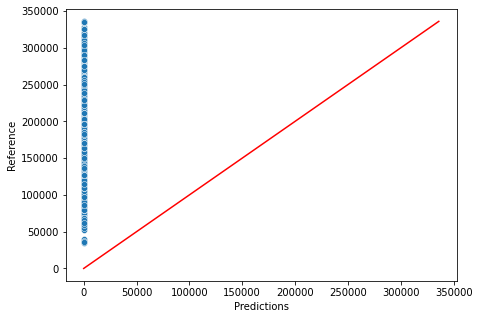

In [ ]:
def plot_predictions(y_true, y_pred): 
    max_preds = max([max(y_pred.tolist()), max(y_true.tolist())])
    min_preds = min([min(y_pred.tolist()), min(y_true.tolist())])
    # plot
    plt.figure(figsize=(7,5))
    sns.scatterplot(x=y_pred, y=y_true)
    sns.lineplot(x=[min_preds,max_preds], y=[min_preds, max_preds], color='red')
    plt.ylabel('Reference')
    plt.xlabel('Predictions')
    plt.show()

plot_predictions(house_price_dummy_model_res['price'], house_price_dummy_model_res['preds'])

In [ ]:
#np.array(X_train['YearBuilt']).reshape(-1, 1)

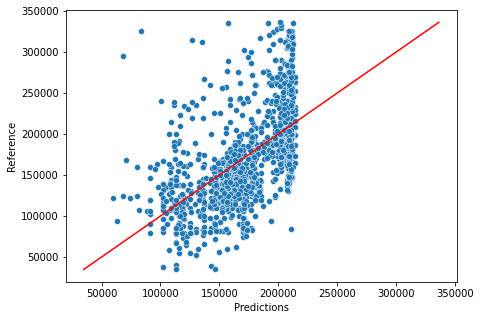

In [ ]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(np.array(X_train['YearBuilt']).reshape(-1, 1), y_train)
plot_predictions(y_train, lm.predict(np.array(X_train['YearBuilt']).reshape(-1, 1)))

In [ ]:
print(
    lm.coef_, 
    lm.intercept_
    )

[1126.4109676] -2049141.248578305


In [ ]:
results = pd.DataFrame({
    'predictions':lm.predict(np.array(X_test['YearBuilt']).reshape(-1, 1)), 
    'true_values':y_test
})
results.head() 

,predictions,true_values
1256,196922.220810,301500
657,125958.329851,149000
152,171014.768555,190000
1081,162003.480815,133000
1276,172141.179523,162000


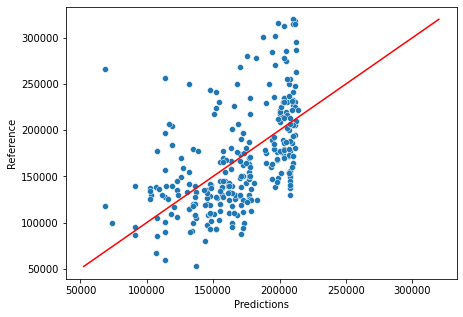

In [ ]:
plot_predictions(results.true_values, results.predictions)

In [ ]:
mse_pre = (results
               .assign(diff = lambda x: (x.true_values - x.predictions)**2)
               .agg({'diff':{'sum','count'}}))
mse = mse_pre.loc['sum'] / mse_pre.loc['count']
mse

diff    2.166467e+09
dtype: float64

In [ ]:
mod_res = {}
mod_res['1st_iter'] = {}
from sklearn.metrics import mean_squared_error
mod_res['1st_iter']['mse'] = mean_squared_error(results.true_values, results.predictions)
mod_res['1st_iter']['mse']

2166466832.2515388

In [ ]:
rmse = (mse_pre.loc['sum'] / mse_pre.loc['count'])**0.5
rmse

diff    46545.320197
dtype: float64

In [ ]:
# check our results with sklearn metrics
mod_res['1st_iter']['rmse'] = mean_squared_error(results.true_values, results.predictions)**0.5
mod_res['1st_iter']['rmse']

46545.32019711046

In [ ]:
# Given that MAPE (mean absolute percentage error) doesn't exist in this version of sklearn, let's write a function:
def mean_abs_perc_error(y_true, y_pred):
    results = pd.DataFrame({'predictions':y_pred,'true_values':y_true})

    mape_pre = (results.assign(diff = lambda x: abs(x.true_values - x.predictions)/x.true_values).agg({'diff':{'sum','count'}}))
    
    mape = mape_pre.loc['sum'] / mape_pre.loc['count']
    
    return mape.values[0]

# from sklearn.metrics import mean_absolute_percentage_error
mod_res['1st_iter']['mape'] = mean_abs_perc_error(results['true_values'], results['predictions'])
mod_res['1st_iter']['mape']
mod_res

{'1st_iter': {'mse': 2166466832.2515388,
  'rmse': 46545.32019711046,
  'mape': 0.2349104257371859}}

 MSE: 2166466832.2515388
          RMSE: 46545.32019711046
          MAE: 36679.49423568294
          MAPE: 0.2349104257371859
213818.38532404555 68511.37050403375


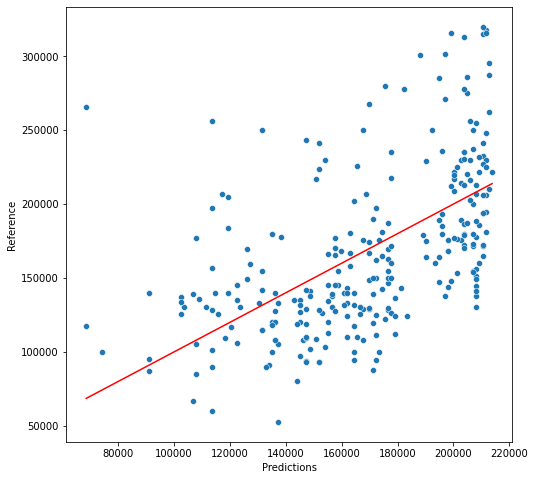

In [ ]:
def plot_predictions(y_true, y_pred): 
    print(f""" MSE: {mean_squared_error(y_true, y_pred)}
          RMSE: {mean_squared_error(y_true, y_pred)**0.5}
          MAE: {mean_absolute_error(y_true, y_pred)}
          MAPE: {mean_abs_perc_error(y_true, y_pred)}""")
    
    max_preds = min([max(y_pred.tolist()), max(y_true.tolist())])
    min_preds = max([min(y_pred.tolist()), min(y_true.tolist())])
    print(max_preds, min_preds)
    
    # plot
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=y_pred, y=y_true)
    sns.lineplot(x=[min_preds,max_preds], y=[min_preds, max_preds], color='red')
    plt.ylabel('Reference')
    plt.xlabel('Predictions')
    plt.show()

    return {'mse': mean_squared_error(y_true, y_pred),
            'rmse': mean_squared_error(y_true, y_pred)**0.5,
            'mae': mean_absolute_error(y_true, y_pred),
            'mape': mean_abs_perc_error(y_true, y_pred)}

mod_res['1st_iter'] = plot_predictions(y_test, results['predictions'])

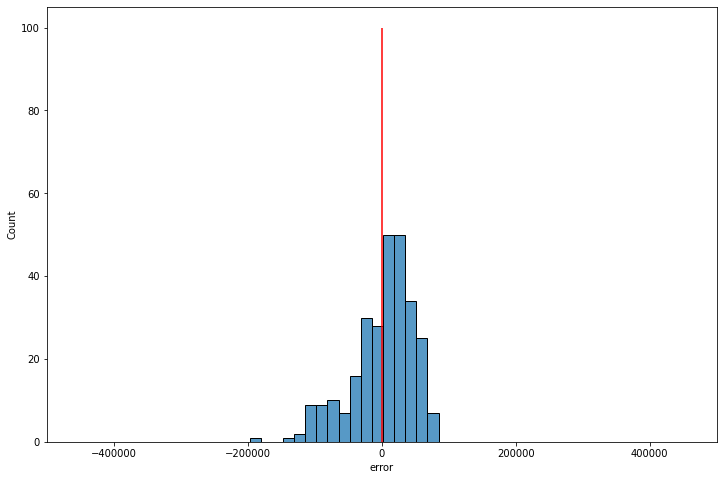

In [ ]:
p_df = results.assign(error = lambda x: x['predictions'] - x['true_values'])

plt.subplots(figsize=(12, 8))
sns.histplot(p_df['error'])
plt.vlines(x=0, ymin=0, ymax=100, color='red')
# big problems with outliers
plt.xlim(-500000, 500000)
plt.show()


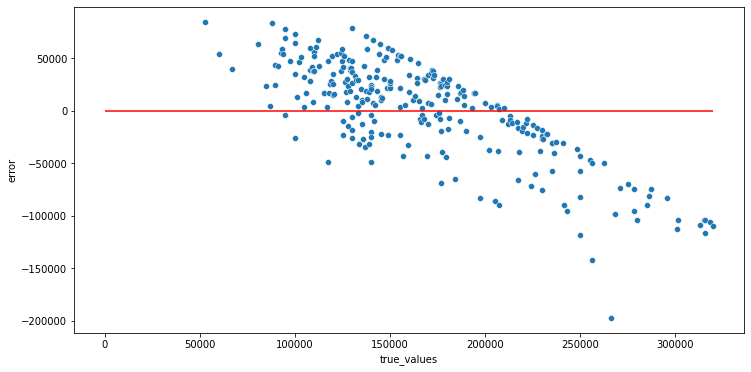

In [ ]:
# another way to visualise our errors
p_df = p_df.sort_values(by='true_values')

plt.subplots(figsize=(12, 6))
sns.scatterplot(data=p_df, x='true_values', y='error')
plt.hlines(y=4, xmin=4, xmax=max(p_df['true_values']), color='red')
plt.show()

In [ ]:
X_train.head()

,Id,Neighborhoods,LotArea,YearBuilt,YearRemodAdd,price_xSQF,Neig_H_size
294,295,15.08,9600,1953,1953,17.395833,9600.0
125,126,13.17,6780,1935,1982,12.463127,6780.0
884,885,15.08,7150,1967,1967,13.986014,7150.0
706,707,13.78,115149,1971,2002,2.622689,115149.0
1120,1121,13.17,8263,1920,1950,14.328936,8263.0


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

cat_pipeline = Pipeline(steps=[('one_hot_enc', OneHotEncoder(drop='first'))])
num_pipeline = Pipeline(
    steps=[('impute', SimpleImputer(strategy='median')),
           ('scale', MinMaxScaler())])


#cat_cols = X_train.select_dtypes('category').columns.tolist()
num_cols = X_train.select_dtypes('float').columns.tolist()
full_processor = ColumnTransformer(transformers=[('number', num_pipeline, num_cols)])

lm_pipeline = Pipeline(steps=[('processor', full_processor), ('model', LinearRegression())])

_ = lm_pipeline.fit(X_train, y_train)
lm_pipeline

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['Neighborhoods',
                                                   'price_xSQF',
                                                   'Neig_H_size'])])),
                ('model', LinearRegression())])


        MSE: 2923000118.8397985
        RMSE: 54064.7770627032
        MAE: 41680.17575657207
        MAPE: 0.2819996647688837
        
336000 137368.1292548666


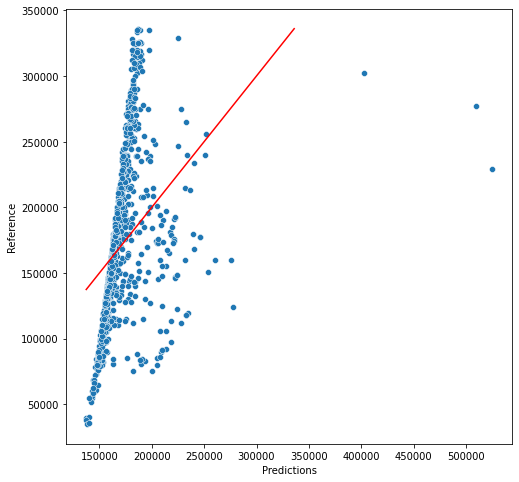

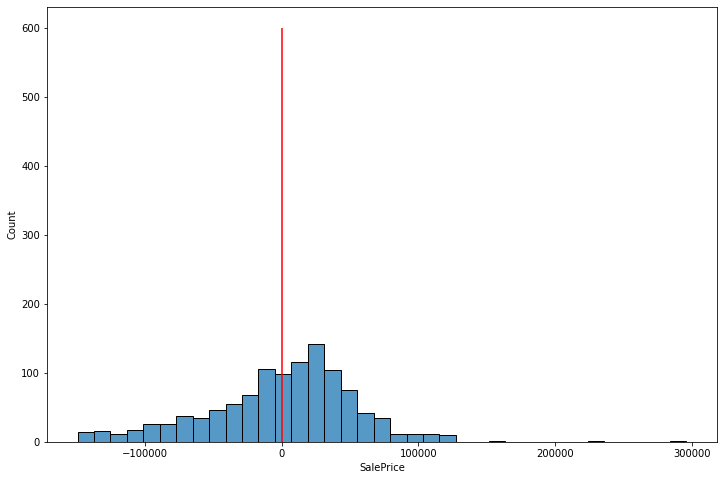

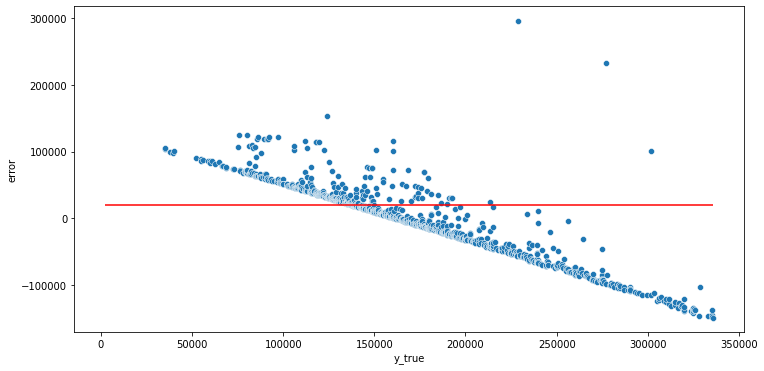

In [ ]:
def plot_predictions(y_true, y_pred): 
    print(
        f"""
        MSE: {mean_squared_error(y_true, y_pred)}
        RMSE: {mean_squared_error(y_true, y_pred)**0.5}
        MAE: {mean_absolute_error(y_true, y_pred)}
        MAPE: {mean_abs_perc_error(y_true, y_pred)}
        """
    )
    max_preds = min([max(y_pred.tolist()), max(y_true.tolist())])
    min_preds = max([min(y_pred.tolist()), min(y_true.tolist())])
    print(max_preds, min_preds)
    # plot
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=y_pred, y=y_true)
    sns.lineplot(x=[min_preds,max_preds], y=[min_preds, max_preds], color='red')
    plt.ylabel('Reference')
    plt.xlabel('Predictions')
    plt.ticklabel_format(style='plain', axis='x')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

    errors = y_pred - y_true
    plt.subplots(figsize=(12, 8))
    sns.histplot(errors)
    plt.vlines(x=0, ymin=0, ymax=600, color='red')
    plt.ticklabel_format(style='plain', axis='x')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

    p_df = (
        pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
        .assign(error = lambda x: x['y_pred'] - x['y_true'])
        .sort_values(by='y_true')
        )

    plt.subplots(figsize=(12, 6))
    sns.scatterplot(data=p_df, x='y_true', y='error')
    plt.hlines(y=20000, xmin=2000, xmax=max(p_df['y_true']), color='red')
    plt.ticklabel_format(style='plain', axis='x')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

    return {
        'mse': mean_squared_error(y_true, y_pred), 
        'rmse': mean_squared_error(y_true, y_pred)**0.5,
        'mae': mean_absolute_error(y_true, y_pred),
        'mape': mean_abs_perc_error(y_true, y_pred)

    }

    

# plot_predictions(y_test, results['predictions'])

mod_res['2nd_iter'] = plot_predictions(y_train, lm_pipeline.predict(X_train))

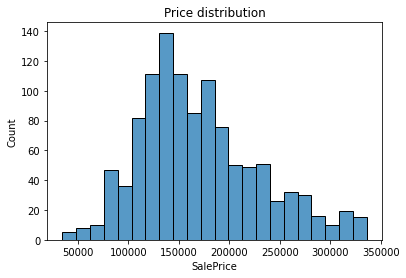

In [ ]:
#Logarithm transformation
sns.histplot(y_train)
plt.title('Price distribution')
plt.show()

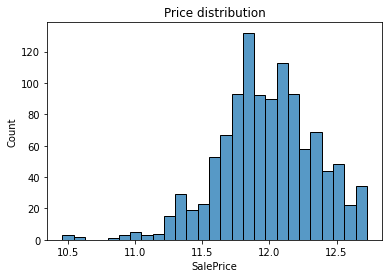

In [ ]:
sns.histplot(np.log(y_train))
plt.title('Price distribution')
plt.show()


        MSE: 5041056150.328129
        RMSE: 71000.39542374485
        MAE: 43720.35540765492
        MAPE: 0.27344555070908527
        
336000 129187.48636662928


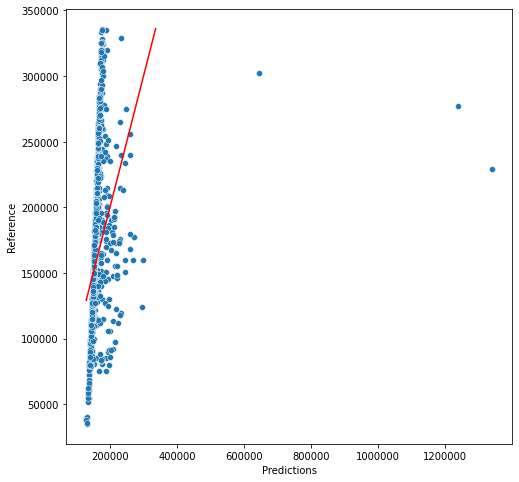

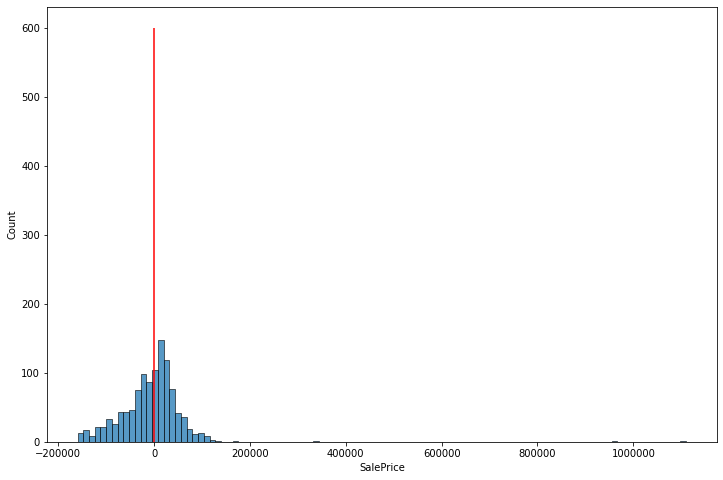

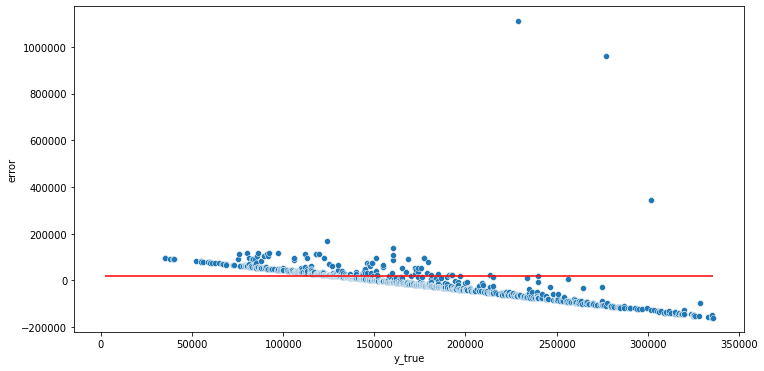

In [ ]:
lm_pipeline.fit(X_train, np.log(y_train))
mod_res['3rd_iter'] = plot_predictions(y_train, np.exp(lm_pipeline.predict(X_train)))

In [ ]:
import numpy as np

# 1. function that given two columns, it returns the corr. coeficient
def corr_coeff(df, var1, var2): 
    temp = df.copy()
    temp['corrn'] = (
        (temp[var1] - np.mean(temp[var1])) * 
        (temp[var2] - np.mean(temp[var2]))
    )
    temp['corr1'] = (temp[var1] - np.mean(temp[var1]))**2
    temp['corr2'] = (temp[var2] - np.mean(temp[var2]))**2
    corrn = sum(temp['corrn'])/np.sqrt(sum(temp['corr1']) * sum(temp['corr2']))
    return corrn


In [ ]:
# 2. Calculate the corr_coeficients for all the columns
temp = pd.concat([X_train, y_train], axis=1)

#print(corr_coeff(temp, 'YearBuilt', 'z'))
#print(corr_coeff(temp, 'price', 'z'))
#print(corr_coeff(temp, 'price', 'x'))
#print(corr_coeff(temp, 'price', 'YearBuilt'))



In [ ]:
num_cols = X_train.select_dtypes('float').columns
results = []
for col in num_cols: res2 = {}
for col2 in num_cols:
  r = corr_coeff(X_train, col, col2)
  print(f'r between {col} and {col2} is {r}')
  res2[col2] = r
  results.append(res2)
dfr = pd.DataFrame(pd.json_normalize(results))
dfr.index = num_cols

dfr.head()


r between Neig_H_size and Neighborhoods is -0.2110635378024477
r between Neig_H_size and price_xSQF is -0.376728723518247
r between Neig_H_size and Neig_H_size is 1.0


,Neighborhoods,price_xSQF,Neig_H_size
Neighborhoods,-0.211064,-0.376729,1.0
price_xSQF,-0.211064,-0.376729,1.0
Neig_H_size,-0.211064,-0.376729,1.0


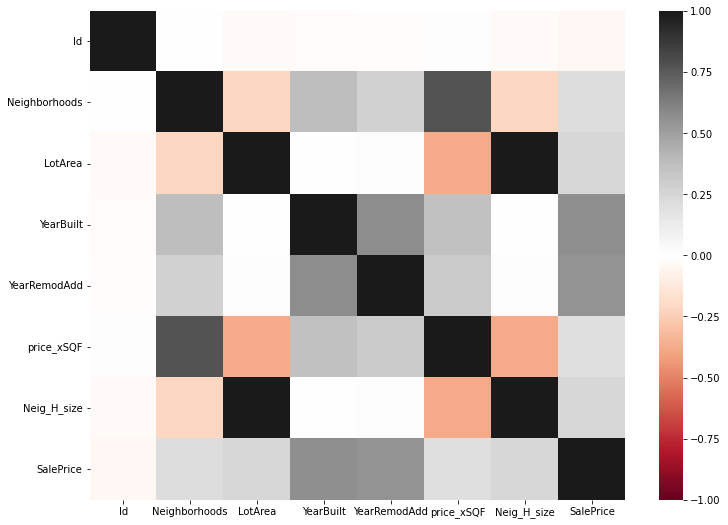

In [ ]:
train = pd.concat([X_train, y_train], axis=1)
plt.subplots(figsize=(12, 9))
sns.heatmap(train.corr(), vmin=-1, vmax=1, cmap='RdGy')
plt.show()

In [ ]:
import seaborn as sns

In [ ]:
import numpy as np

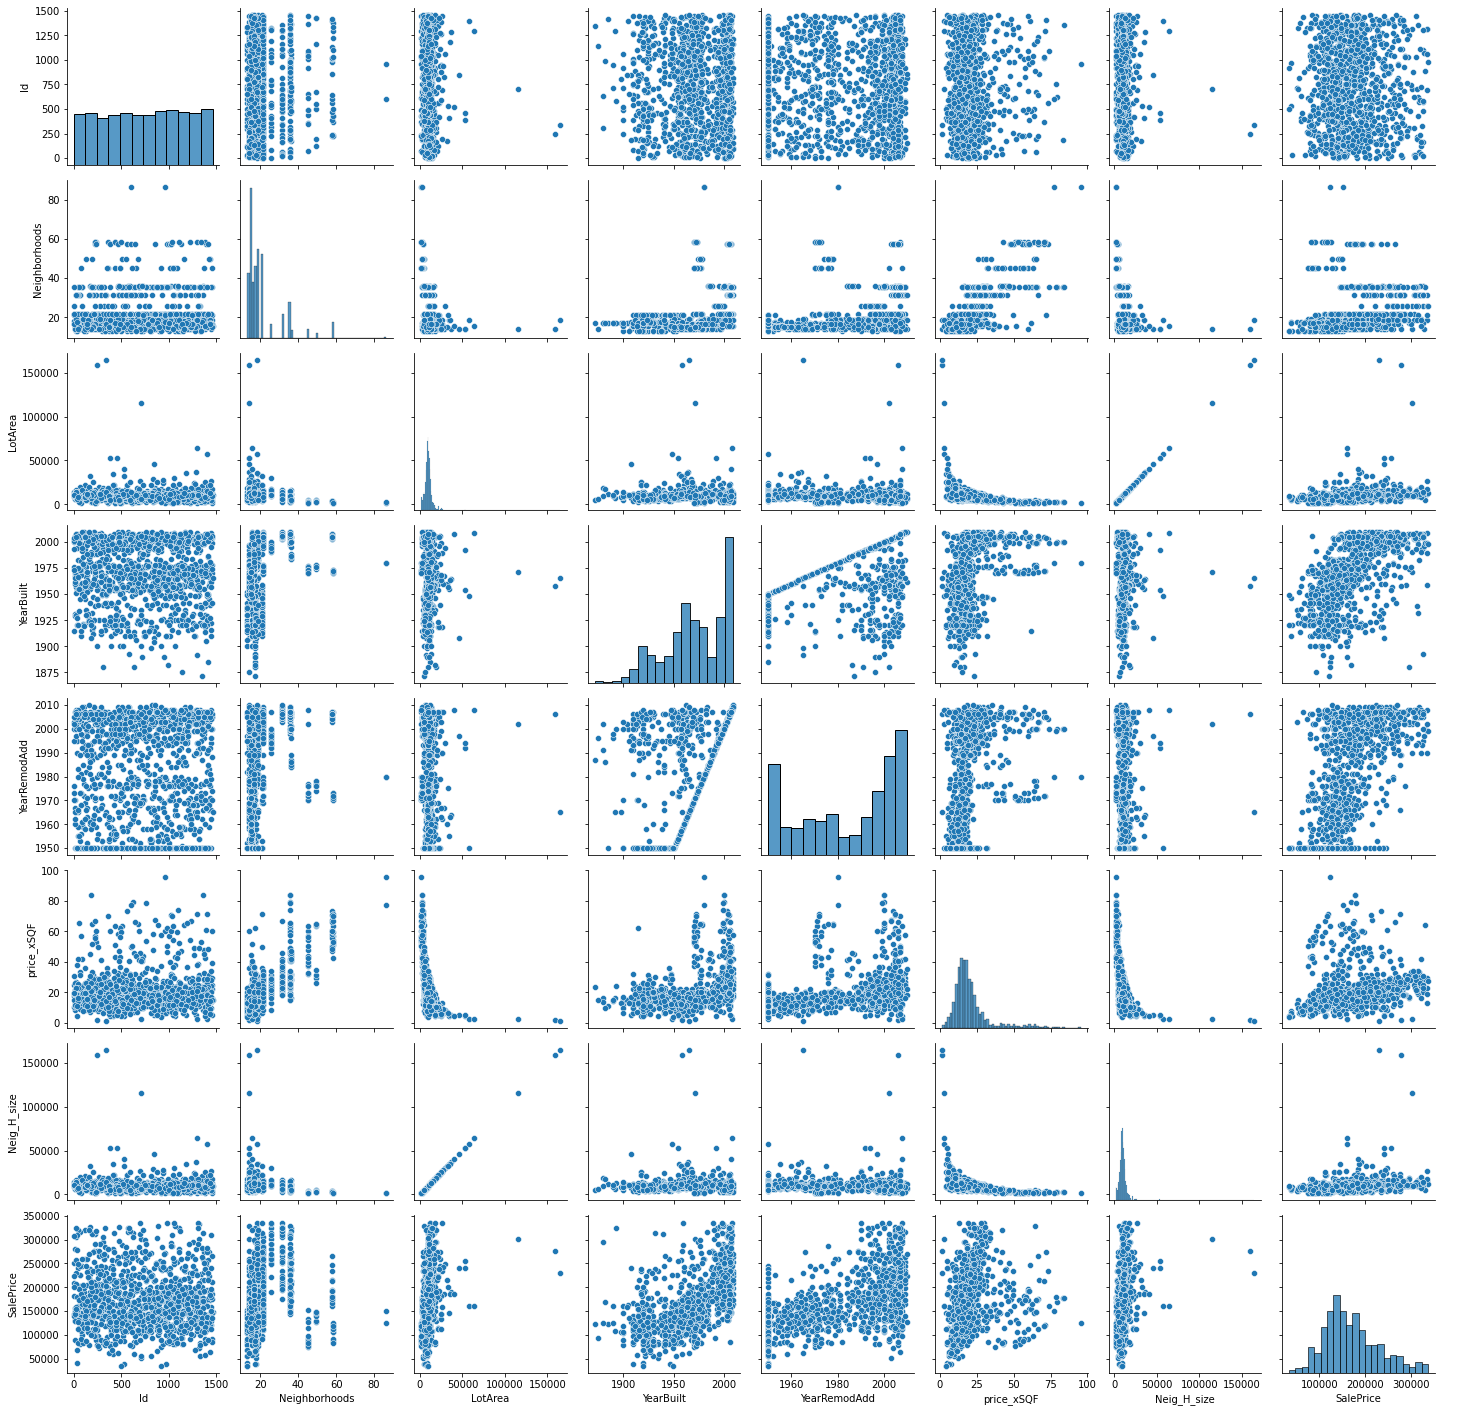

In [ ]:
g = sns.PairGrid(train)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

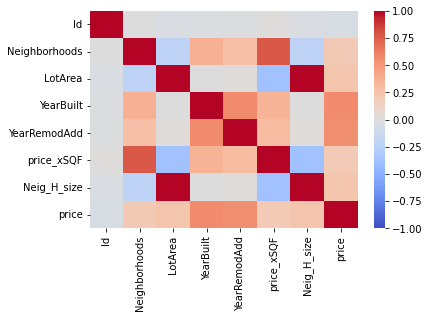

In [ ]:
train = X_train.assign(price = y_train)

sns.heatmap(train.corr(), vmin=-1, vmax=1, cmap='coolwarm')

In [ ]:
train.corr()['price'].sort_values()

Id              -0.042335
price_xSQF       0.208252
Neighborhoods    0.213580
LotArea          0.246833
Neig_H_size      0.246833
YearRemodAdd     0.548712
YearBuilt        0.568655
price            1.000000
Name: price, dtype: float64

In [ ]:
X = Neig_price_copy.drop(columns=['SalePrice'])
y = Neig_price_copy['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=8)

X_train.head()

from sklearn.preprocessing import OrdinalEncoder
num_cols = X_train.select_dtypes('float').columns.tolist()
encoding = ColumnTransformer(transformers=[('number', "passthrough", num_cols)])

lm_pipeline = Pipeline(steps=[('encoding', encoding), 
                              ('scale', MinMaxScaler()),
                              ('model', RandomForestRegressor())])

_ = lm_pipeline.fit(X_train, np.log(y_train))


        MSE: 77039673.5334938
        RMSE: 8777.2247056512
        MAE: 4407.916452779881
        MAPE: 0.025597426239189237
        
316503.3651227688 62266.60302101673


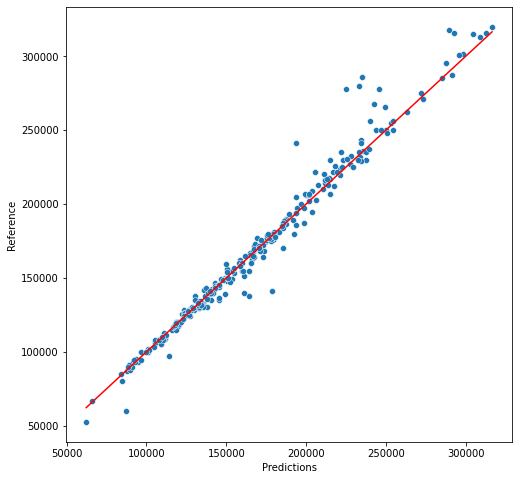

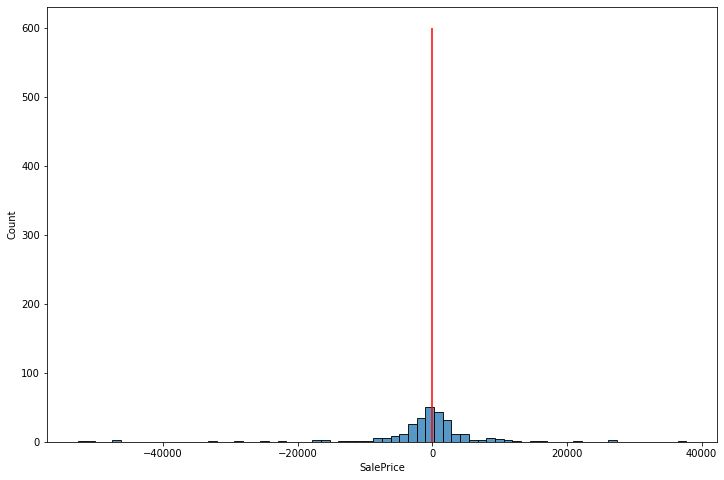

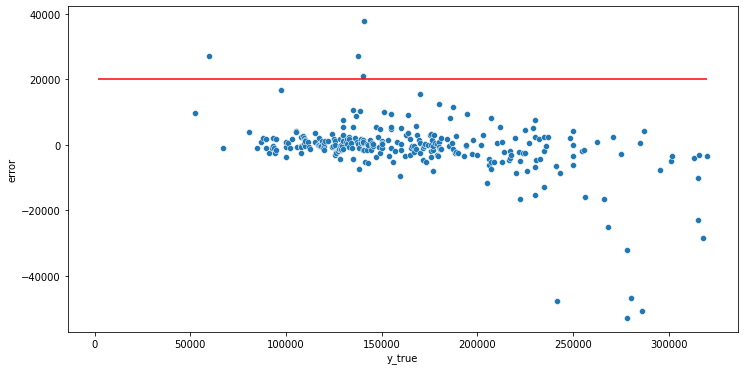

In [ ]:
y_preds = np.exp(lm_pipeline.predict(X_test))
mod_res['4th_iter'] = plot_predictions(y_test, y_preds)

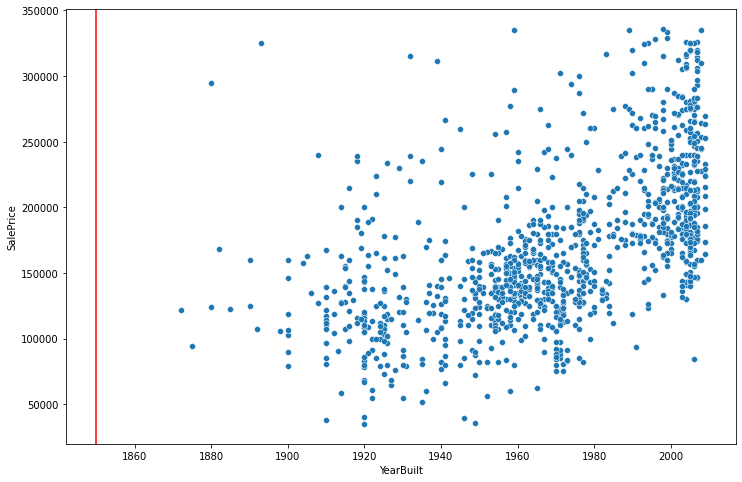

In [ ]:
#Iteration Outliers 
plt.subplots(figsize=(12, 8))
sns.scatterplot(x=X_train['YearBuilt'], y=y_train)
plt.axvline(x = 1850, ymin=0, ymax=28000, c='red')
plt.show()


        MSE: 497580575.71076185
        RMSE: 22306.51419901285
        MAE: 10803.83966462898
        MAPE: 0.052657721886464205
        
285676.8320597054 57678.48223609615


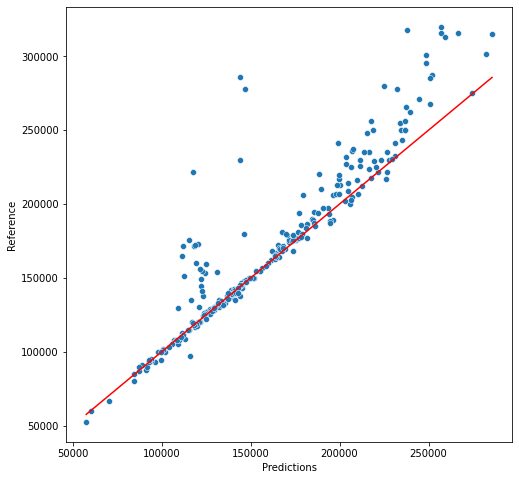

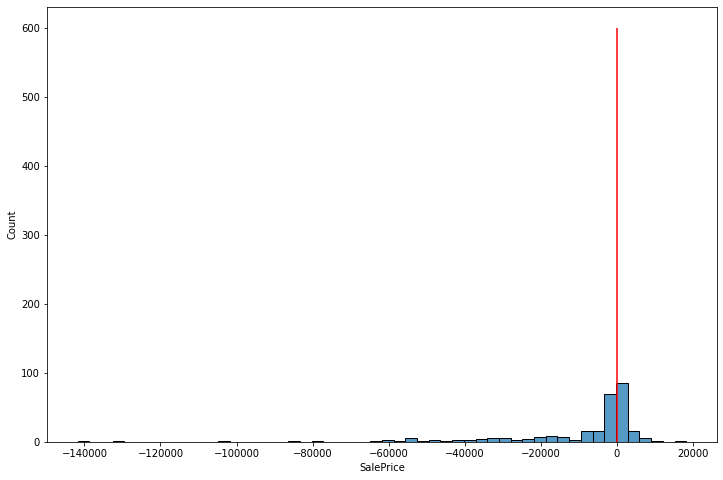

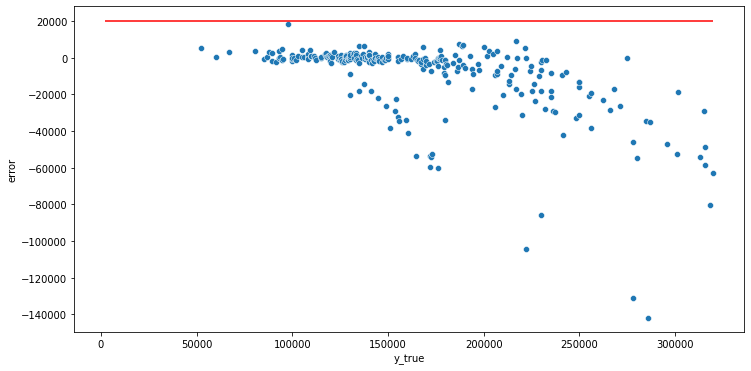

In [ ]:
X_filt = (
pd.concat([X_train, y_train], axis=1)
    .query("YearBuilt < 1973")
)
X_train_filt = X_filt.drop(columns='SalePrice')
y_train_filt = X_filt['SalePrice']
_ = lm_pipeline.fit(X_train_filt, np.log(y_train_filt))
y_pred = np.exp(lm_pipeline.predict(X_test))

mod_res['5th_iter'] = plot_predictions(y_test, y_pred)

--------------------
LinearRegression()

        MSE: 2444548990.8984
        RMSE: 49442.38051407314
        MAE: 38516.98571863732
        MAPE: 0.23628086196326337
        
320000 134406.69258384866


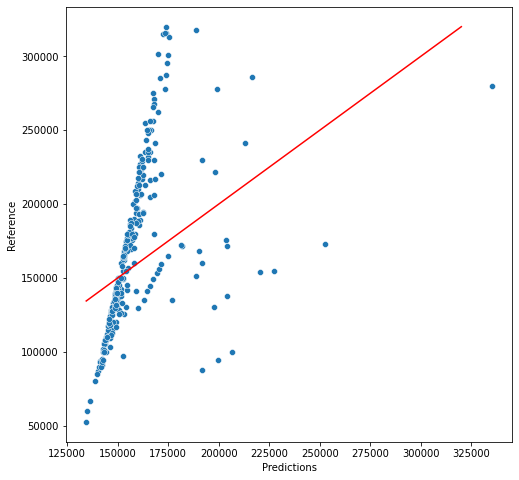

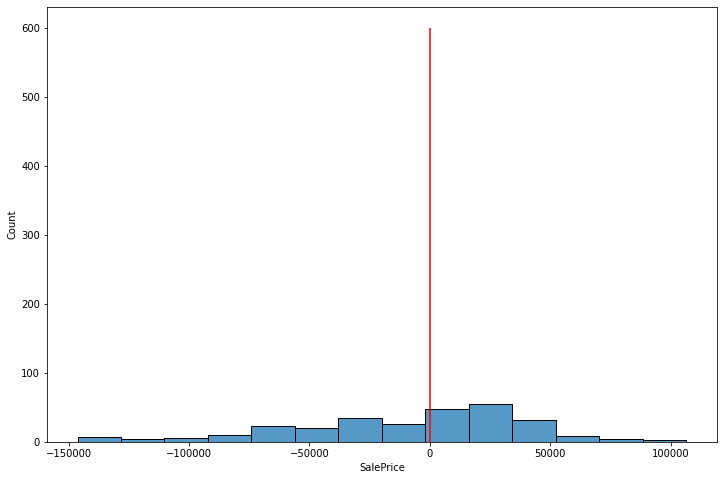

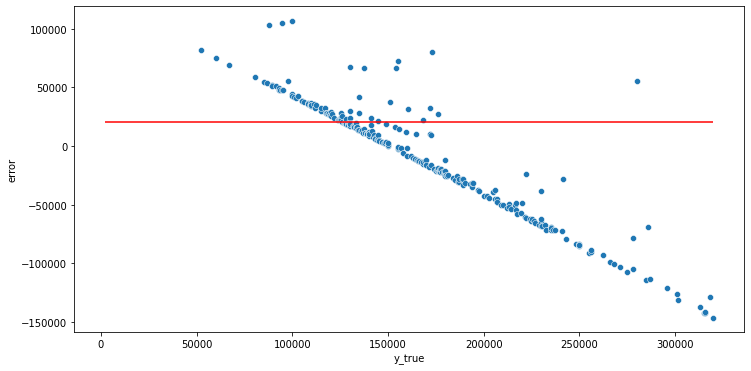

--- 0.9226174354553223 seconds ---
--------------------
RandomForestRegressor()

        MSE: 78052559.80116102
        RMSE: 8834.735978010945
        MAE: 4555.501294874975
        MAPE: 0.02642680937204564
        
319053.28519266425 62339.55447700434


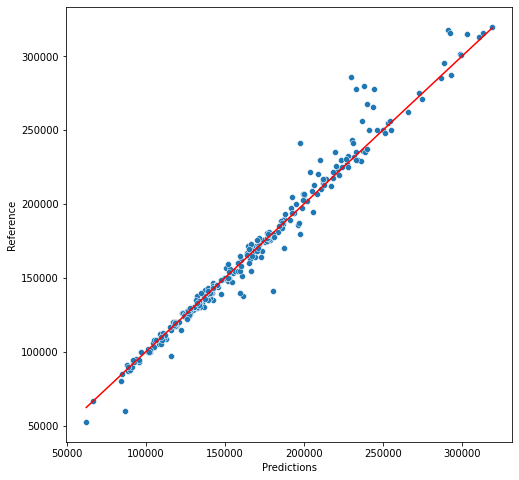

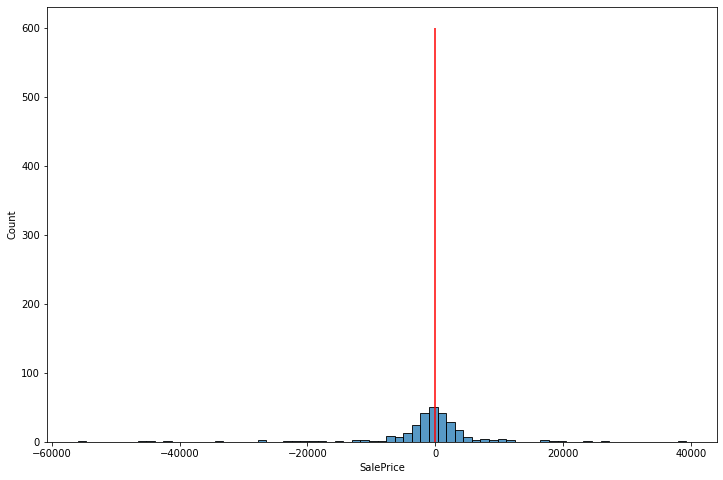

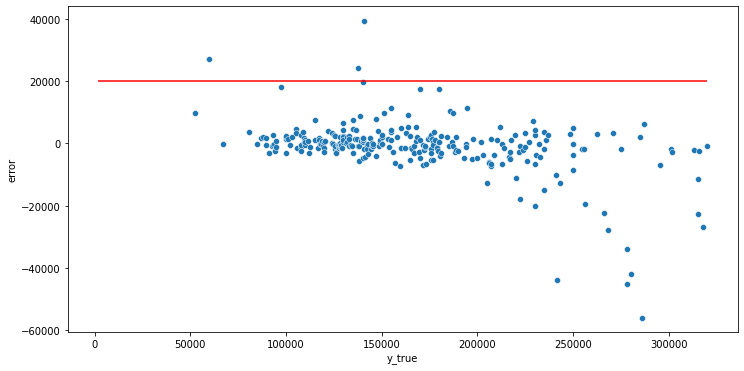

--- 1.4760842323303223 seconds ---
--------------------
KNeighborsRegressor()

        MSE: 341570942.4913295
        RMSE: 18481.637981827516
        MAE: 10813.99706413646
        MAPE: 0.0630246183593642
        
293194.8070273516 59375.224775180744


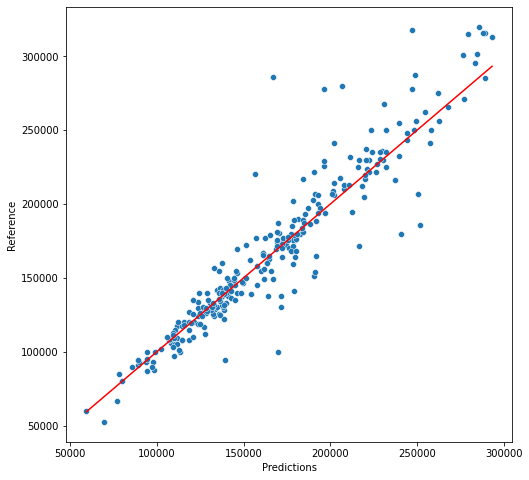

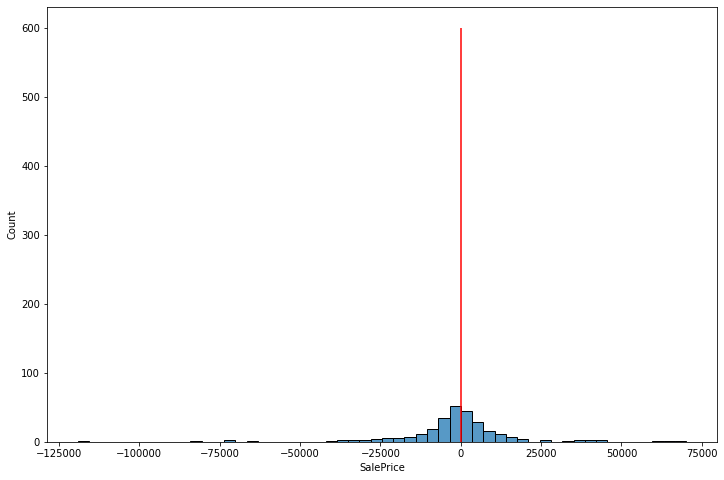

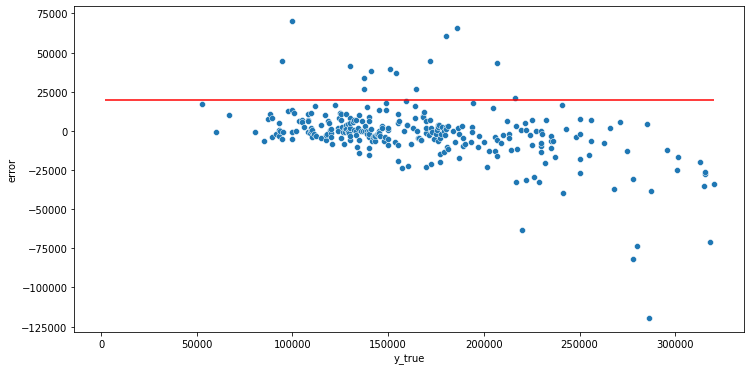

--- 0.9946548938751221 seconds ---
--------------------
SVR()

        MSE: 307197214.8848995
        RMSE: 17527.042388403683
        MAE: 12813.805185321302
        MAPE: 0.07790651662627056
        
320000 66086.84039184918


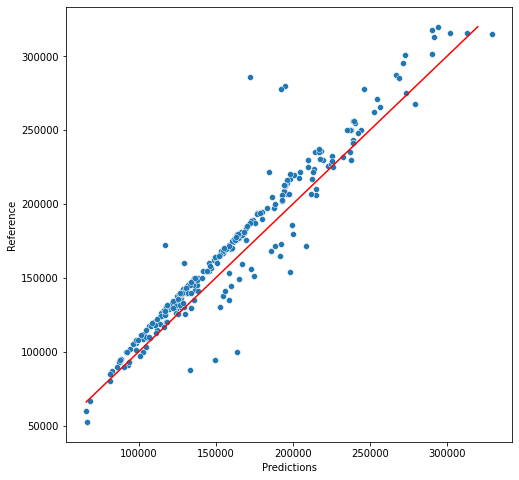

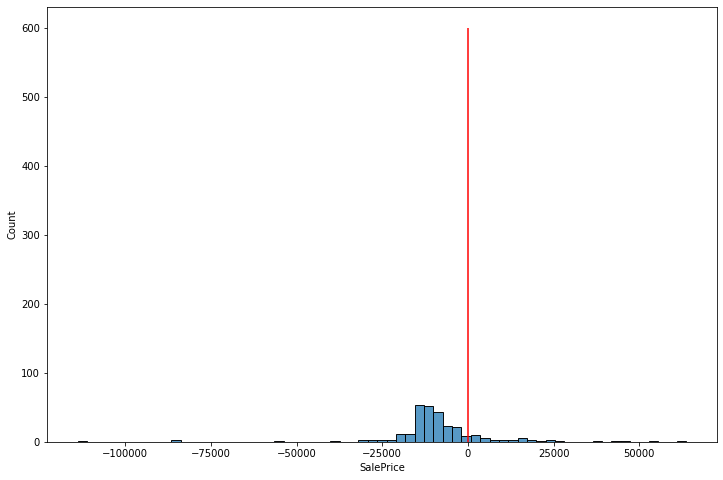

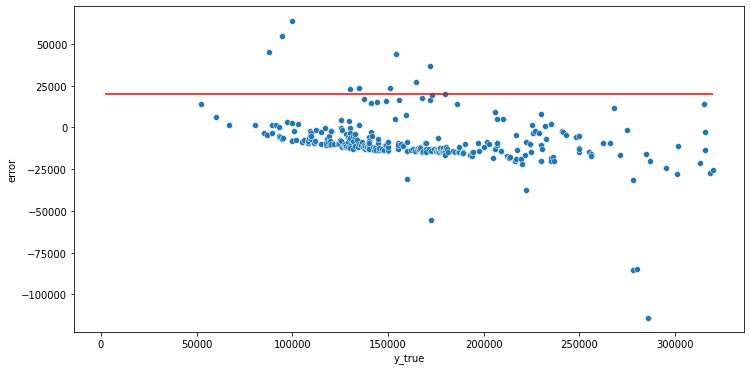

--- 0.9932186603546143 seconds ---


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import time

for model in [LinearRegression(), RandomForestRegressor(), KNeighborsRegressor(), SVR()]: 
    print('-'*20)
    print(model)
    start_time = time.time()
    lm_pipeline = Pipeline(steps=[
        ('encoding', encoding), 
        ('scale', MinMaxScaler()),
        ('model', model)
    ])
    P_pred = lm_pipeline.fit(X_train, np.log(y_train))
    y_pred = np.exp(lm_pipeline.predict(X_test))
    P_pred = plot_predictions(y_test, y_pred)
    print("--- %s seconds ---" % (time.time() - start_time), sep='/n')